## Load packages

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

## Settings

In [2]:
SEAFILE_PATH = os.path.abspath(os.path.join("../../../..", "Seafile", "Detecting-Objects", "DataCollection"))
IMAGE_PATH = os.path.join(SEAFILE_PATH, "images")
LABEL_PATH = os.path.join(SEAFILE_PATH, "labels")
OBJECT_CLASS = "bowl2"

OBJECT_PATH = os.path.join(IMAGE_PATH, OBJECT_CLASS)

RGB_IMAGE_PATH = os.path.join(OBJECT_PATH, "rgb")
DEPTH_IMAGE_PATH = os.path.join(OBJECT_PATH, "depth")

In [3]:
SEAFILE_PATH = os.path.abspath(os.path.join("../../../..", "Seafile", "Detecting-Objects", "DataCollection"))
IMAGE_PATH = os.path.join(SEAFILE_PATH, "images")

RGB_IMAGE_PATH = os.path.join(IMAGE_PATH, "gemittlet_diesmal_wirklich", "rgb")
DEPTH_IMAGE_PATH = os.path.join(IMAGE_PATH, "gemittlet_diesmal_wirklich", "depth")

In [141]:
def get_filtered_contours(contours):
    # Confines of the desk
    xmin, xmax, ymin, ymax = 340, 940, 60, 660
    filtered_contours = []
    
    for contour in contours:
        x, y, w, h, = cv2.boundingRect(contour) 

        if w < 15 and h < 15:
            continue
            
        if w > 500 and h > 500:
            continue

        if x+w > xmax or y+h > ymax:
            pass

        if w*h < 500:
            pass 

        if w/h > 2:
            pass

        filtered_contours.append((x, y, x+w, y+h)) 
    return filtered_contours

In [142]:
# Combine multiple bounding boxes to one single bounding box
def combine_overlapping_contour(contours):
    box_xmin, box_xmax, box_ymin, box_ymax = 0, 0, 0, 0

    for contour in contours:
        x, y, w, h, = contour

        if box_xmin == 0 or x < box_xmin:
            box_xmin = x

        if box_xmax == 0 or x + w > box_xmin:
            box_xmax = x + w

        if box_ymin == 0 or y < box_ymin:
            box_ymin = y

        if box_ymax == 0 or y + h < box_ymax:
            box_ymax = y + h    
            
    return box_xmin, box_xmax, box_ymin, box_ymax

In [143]:
def get_bounding_boxes(depth_img):
    xmin, xmax, ymin, ymax = 340, 940, 60, 660
     
    # Remove pixels outside of table
    mask = np.zeros_like(depth_img)
    cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), (255, 255, 255), -1)
    depth_img = cv2.bitwise_and(depth_img, mask)

    BLUR_AMOUNT = 3
    CANNY_THRESH = 90
    KERNEL_SIZE = 3
    ITERATION_COUNT = 3
    
    blurred = cv2.GaussianBlur(depth_img, (BLUR_AMOUNT, BLUR_AMOUNT), 0)
    edged = cv2.Canny(blurred, CANNY_THRESH, CANNY_THRESH, CANNY_THRESH)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (KERNEL_SIZE, KERNEL_SIZE))
    dilate = cv2.dilate(edged, kernel, iterations=ITERATION_COUNT)
    
    dilate = cv2.bitwise_and(dilate, mask)

    # find the contours in the dilated image
    contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[2:])

    _, axarr = plt.subplots(1, 2)
    axarr[0].imshow(dilate)
    axarr[1].imshow(depth_img)
    plt.show()

    filtered_contours = get_filtered_contours(contours)
    
    return filtered_contours if filtered_contours else []

In [144]:
def get_bounding_box(depth_img):
    xmin, xmax, ymin, ymax = 340, 940, 60, 660
     
    # Remove pixels outside of table
    mask = np.zeros_like(depth_img)
    cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), (255, 255, 255), -1)

    CANNY_THRESH = 10
    KERNEL_SIZE = 5
    ITERATION_COUNT = 3
    
    edged = cv2.Canny(depth_img, CANNY_THRESH, CANNY_THRESH, CANNY_THRESH)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (KERNEL_SIZE, KERNEL_SIZE))
    dilate = cv2.dilate(edged, kernel, iterations=ITERATION_COUNT)
    dilate = cv2.bitwise_and(dilate, mask)

    # find the contours in the dilated image
    contours, _ = cv2.findContours(dilate, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[2:])

    _, axarr = plt.subplots(1, 2)
    axarr[0].imshow(dilate)
    axarr[1].imshow(depth_img)
    plt.show()

    filtered_contours = get_filtered_contours(contours)
    
    return filtered_contours[-1] if filtered_contours else []

In [157]:
def draw_boxes(object_name):
    xmin, xmax, ymin, ymax = 340, 940, 60, 660
    
    
    OBJECT_PATH = os.path.join(IMAGE_PATH, object_name)
    #RGB_IMAGE_PATH = os.path.join(OBJECT_PATH, "rgb")
    #DEPTH_IMAGE_PATH = os.path.join(OBJECT_PATH, "depth")
    
    RGB_IMAGE_PATH = os.path.join(IMAGE_PATH, "gemittlet_diesmal_wirklich", "rgb")
    DEPTH_IMAGE_PATH = os.path.join(IMAGE_PATH, "gemittlet_diesmal_wirklich", "depth")

    files = os.listdir(RGB_IMAGE_PATH)
    
    for file_name in files:
        # Read images
        rgb_img = cv2.imread(os.path.join(RGB_IMAGE_PATH, file_name), cv2.IMREAD_UNCHANGED).astype('uint8')
        depth_img = cv2.imread(os.path.join(DEPTH_IMAGE_PATH, file_name), cv2.IMREAD_UNCHANGED).astype('uint8')

        boxes = get_bounding_box(depth_img)        
        print(boxes)
        
        # Print boxes on image
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)     
        result = rgb_img.copy()
        if len(boxes) > 0:
            cv2.rectangle(result, (boxes[0], boxes[1]), (boxes[2], boxes[3]), (0, 255, 0), 1)
    
        plt.imshow(result)
        cv2.imwrite(os.path.join(RGB_IMAGE_PATH, "..", "annotation", file_name),cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

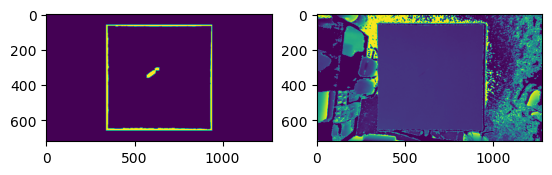

(570, 302, 642, 362)


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - imwrite() missing required argument 'img' (pos 2)
>  - imwrite() missing required argument 'img' (pos 2)


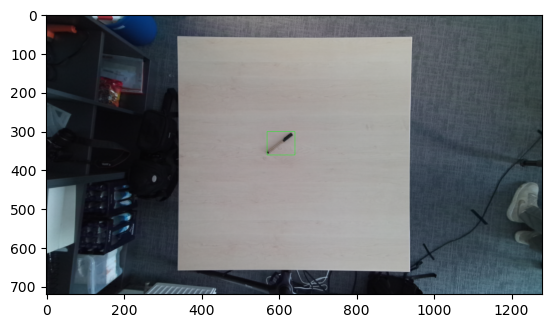

In [158]:
draw_boxes("cup")